In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import keras
import tensorflow as tf
from keras.applications import ResNet152V2, ResNet50V2
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:
* Here we split the data in a way that we have bacteria, virus and normal images. in the proper way- some of each and not in a total randomize way
* TODO: Need to chek why the depth of the image is 3 and not 1 as in regular cnn network

In [22]:
# IMG_SIZE = 150
IMG_DEPTH = 3
IMG_SIZE = 224
BATCH = 16
SEED = 42

normal_dataset = glob.glob('/content/drive/MyDrive/Deep Learning Project/chest_xray/NORMAL/*.jpeg')
pneumonia_dataset = glob.glob('/content/drive/MyDrive/Deep Learning Project/chest_xray/PNEUMONIA/*.jpeg')
virus_dataset = list(filter(lambda x: 'virus' in x, pneumonia_dataset))
bacterial_dataset = list(filter(lambda x: 'bacteria' in x, pneumonia_dataset))


Generate Train, Validation and Test Sets:

In [23]:
def split_data(dataSet, testSize, valSize):
    train, test= train_test_split(dataSet, test_size=testSize, random_state=SEED, shuffle=True)
    train, val= train_test_split(train, test_size=valSize, random_state=SEED, shuffle=True)
    return train, test, val


train_normal, test_normal, val_normal = split_data(normal_dataset, 0.15, 0.038)
train_bacterial, test_bacterial, val_bacterial = split_data(bacterial_dataset, 0.05, 0.0095)
train_virus, test_virus, val_virus = split_data(virus_dataset, 0.075, 0.019)



train = [x for x in train_normal]
train.extend([x for x in train_bacterial])
train.extend([x for x in train_virus])

test = [x for x in test_normal]
test.extend([x for x in test_bacterial])
test.extend([x for x in test_virus])

val = [x for x in val_normal]
val.extend([x for x in val_bacterial])
val.extend([x for x in val_virus])

df_train = pd.DataFrame(np.concatenate([['Normal']*(len(train_normal)) , ['Pneumonia']*(len(train_bacterial) + len(train_virus))]), columns = ['class'])
df_train['image'] = [x for x in train]

df_val = pd.DataFrame(np.concatenate([['Normal']*(len(val_normal)) , ['Pneumonia']*(len(val_bacterial) + len(val_virus))]), columns = ['class'])
df_val['image'] = [x for x in val]

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*(len(test_bacterial) + len(test_virus))]), columns = ['class'])
df_test['image'] = [x for x in test]



Perform Data Augmentation on Each Set:
* TODO: Need to check why we are doing data augmentation on all 3 sets
  and not just on the training set as in the regular cnn network.

In [24]:

# With data augmentation to prevent overfitting and handling the imbalance in dataset
# Because the dataset is small we "increase" the dataset by change of images parameters.
# In this way we increase our dataset and prevent overfitting.

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(df_train,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = test_datagen.flow_from_dataframe(df_val,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 5262 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.
Found 489 validated image filenames belonging to 2 classes.


Create and Freeze the Base Model:

In [25]:
# --------- create base model ----------#
base_model = ResNet50V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH),
    include_top=False)

# --------- FREEZE base model ----------#
base_model.trainable = False

Get the Pre-Trained Model:

In [26]:
# --------- get pretrained model ----------#
keras.backend.clear_session()

#Input shape = [width, height, color channels]
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH))

x = base_model(inputs, training=False)

# Head
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.2)(x)

#Final Layer (Output)
output = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=[inputs], outputs=output)

Compile and Summerize The Model:
* As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [27]:
base_lr = 0.001
model.compile(loss='binary_crossentropy',
               optimizer = Adam(learning_rate=base_lr), metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

Train the Model Before Fine Tuning

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-10,
    cooldown = 0,
    verbose = 1
)

initial_epochs = 10

history = model.fit(ds_train,
          batch_size=BATCH, epochs=initial_epochs,
          validation_data=ds_val,
          callbacks=[learning_rate_reduction],
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_val)/BATCH))
# With Early Stopping:
# history = model.fit(ds_train,
#           batch_size=BATCH, epochs=Epochs,
#           validation_data=ds_val,
#           callbacks=[early_stop, learning_rate_reduction],
#           steps_per_epoch=(len(df_train)/BATCH),
#           validation_steps=(len(df_val)/BATCH))

Epoch 1/10
328/328 [==============================] - 140s 416ms/step - loss: 0.2069 - accuracy: 0.9187 - val_loss: 0.1307 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 2/10
328/328 [==============================] - 132s 400ms/step - loss: 0.1497 - accuracy: 0.9430 - val_loss: 0.1082 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 3/10
328/328 [==============================] - 130s 395ms/step - loss: 0.1405 - accuracy: 0.9468 - val_loss: 0.0983 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 4/10
328/328 [==============================] - 132s 402ms/step - loss: 0.1274 - accuracy: 0.9519 - val_loss: 0.0944 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 5/10
328/328 [==============================] - 130s 395ms/step - loss: 0.1226 - accuracy: 0.9525 - val_loss: 0.0860 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 6/10
328/328 [==============================] - 130s 395ms/step - loss: 0.1165 - accuracy: 0.9538 - val_loss: 0.0691 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 7/10
328/328 [==========================

Evaluate the Accuracy and Loss (Before Fine Tuning):

In [29]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs (Before Fine Tuning):

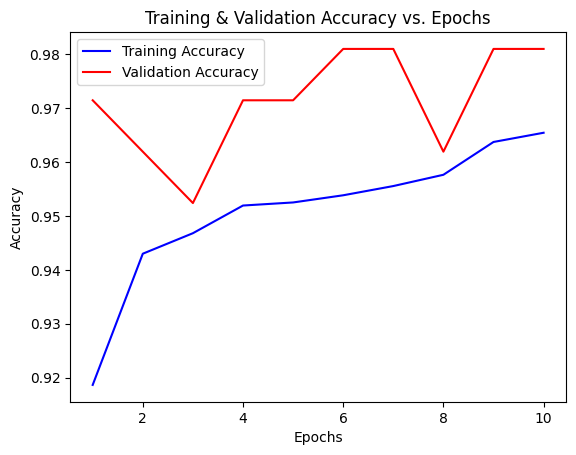

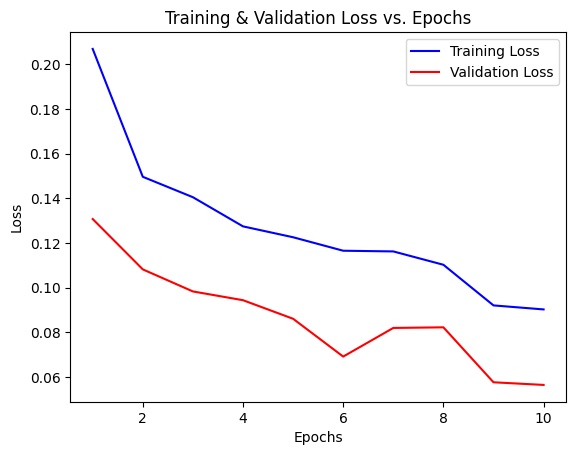

In [30]:
accuracy_fig = plt.figure()
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy vs. Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

loss_fig = plt.figure()
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss vs. Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

Fine Tuning

UnFreeze the Top Layers:

In [31]:
# Set the base_model as trainable
base_model.trainable = True

# Print the number of layers in the base_model
print(f"Number of Layers In the Base Model: {len(base_model.layers)}")

# Specify the layer index from which fine-tuning will start
fine_tune_from = -70

# Iterate through the layers of the base_model
# and set them as non-trainable up to the fine_tune_from index
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False


Number of Layers In the Base Model: 190


**TODO:** check why we need to split the validation set from the training set in advance instead of using validation split.

the following comment is not working:
we use dataaugmantion on all of the training set (including the validatio set because we use validation split in model/fit method). maybe we should check what is the difference in the results if we split the validation set before we train and use data augmentation only on the actual training set.

Compile and Summerize The Model:
* It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

* It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way.

In [32]:
model.compile(loss='binary_crossentropy',
               optimizer = Adam(learning_rate=base_lr/10), metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

Train the Model:

In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-10,
    cooldown = 0,
    verbose = 1
)

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                        batch_size=BATCH,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=ds_val,
                        callbacks=[learning_rate_reduction],
                        steps_per_epoch=(len(df_train)/BATCH),
                        validation_steps=(len(df_val)/BATCH))
# With Early Stopping
# history_fine = model.fit(ds_train,
#                         batch_size=BATCH,
#                         epochs=total_epochs,
#                         initial_epoch=history.epoch[-1],
#                         validation_data=ds_val,
#                         callbacks=[early_stop, learning_rate_reduction],
#                         steps_per_epoch=(len(df_train)/BATCH),
#                         validation_steps=(len(df_val)/BATCH))

Epoch 10/20
328/328 [==============================] - 140s 414ms/step - loss: 0.1842 - accuracy: 0.9365 - val_loss: 0.0317 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 11/20
328/328 [==============================] - 132s 403ms/step - loss: 0.1047 - accuracy: 0.9605 - val_loss: 0.0375 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 12/20
329/328 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9721
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
328/328 [==============================] - 134s 407ms/step - loss: 0.0787 - accuracy: 0.9721 - val_loss: 0.0799 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 13/20
328/328 [==============================] - 131s 399ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.0890 - val_accuracy: 0.9714 - lr: 2.0000e-05
Epoch 14/20
329/328 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9865
Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
328/328

Evaluate the Accuracy and Loss (After Fine Tuning):

In [34]:
test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

train_acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
train_loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
epochs = range(1, len(train_acc) + 1)

Test Loss: 0.06884513050317764
Test Accuracy: 0.9754601120948792


Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs (After Fine Tuning):

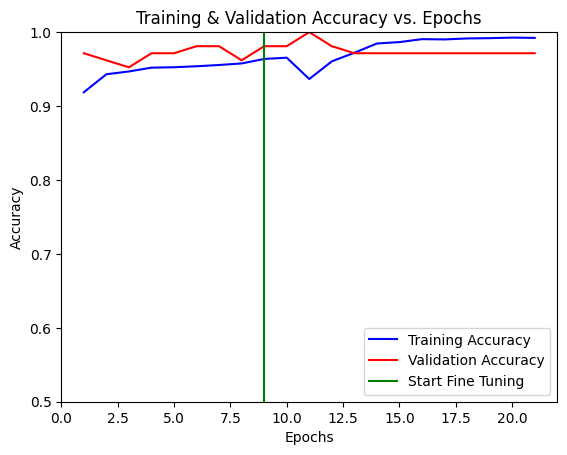

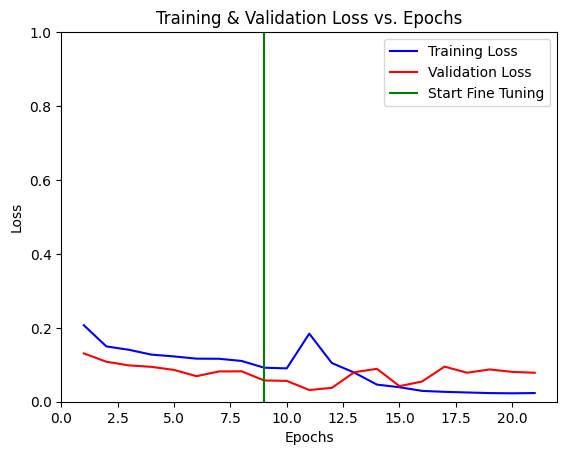

In [35]:
accuracy_fig = plt.figure()
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy vs. Epochs')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'g-',label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

loss_fig = plt.figure()
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss vs. Epochs')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'g-',label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()


Precision vs. Recall Graph with F1-Score Points Marked on the Plot:

Threshold: 0.10, Precision: 0.96, Recall: 0.98
Threshold: 0.15, Precision: 0.97, Recall: 0.98
Threshold: 0.20, Precision: 0.97, Recall: 0.98
Threshold: 0.25, Precision: 0.97, Recall: 0.98
Threshold: 0.30, Precision: 0.98, Recall: 0.97
Threshold: 0.35, Precision: 0.98, Recall: 0.97
Threshold: 0.40, Precision: 0.98, Recall: 0.97
Threshold: 0.45, Precision: 0.98, Recall: 0.97
Threshold: 0.50, Precision: 0.98, Recall: 0.97
Threshold: 0.55, Precision: 0.99, Recall: 0.96
Threshold: 0.60, Precision: 0.99, Recall: 0.95
Threshold: 0.65, Precision: 0.99, Recall: 0.95
Threshold: 0.70, Precision: 0.99, Recall: 0.94
Threshold: 0.75, Precision: 1.00, Recall: 0.94
Threshold: 0.80, Precision: 1.00, Recall: 0.93
Threshold: 0.85, Precision: 1.00, Recall: 0.93
Threshold: 0.90, Precision: 1.00, Recall: 0.92


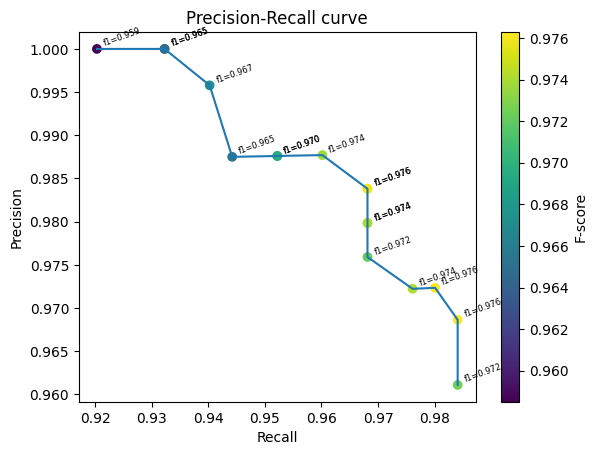

Maximum F1-score: 0.976
Corresponding threshold: 0.15


In [36]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
y_test = df_test['class'].copy().map(num_label).astype('int')
ds_test.reset()
y_scores = model.predict(ds_test, steps=len(ds_test), verbose=0)  # X_test is the input data for testing

# y_true is the true binary labels
# y_scores is the predicted scores for each sample
# Define thresholds
thresholds = np.arange(0.1, 0.95, 0.05)

precision = []  # Initialize an empty list for precision scores
recall = []  # Initialize an empty list for recall scores

for t in thresholds:
    y_pred = y_scores > t
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    precision.append(p)
    recall.append(r)
    print(f'Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}')

f_scores = [f1_score(y_test, y_scores > t) for t in thresholds]

# plot the precision-recall curve
plt.plot(recall, precision)

# plot the F-score points per threshold on the precision-recall curve
plt.scatter(recall, precision, c=f_scores, cmap='viridis')
plt.colorbar(label='F-score')

# add text annotations with the F-score values
for r, p, f in zip(recall, precision, f_scores):
    plt.annotate(f'f1={f:.3f}', (r, p), xytext=(4, 2), textcoords='offset points', fontsize=6, rotation=20)

plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# # Set the number of digits after the decimal point on the x-axis
# ax = plt.gca()
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.show()

# Find the maximum F1-score and its corresponding threshold
max_f1_score = max(f_scores)
max_threshold = thresholds[f_scores.index(max_f1_score)]

print(f"Maximum F1-score: {max_f1_score:.3f}")
print(f"Corresponding threshold: {max_threshold:.2f}")
